# Introduction
The goal for this notebook is to produce a submission file to participate in Kaggle Histopathologic Cancer Detection.

### Dataset description:
The dataset consists on 277485 files divided into train and test files. The files are: one csv file with label information for the training set and tif files with pictures of healthy and cancerous tissue. All images are classified. It seems that there is no need for extensive EDA

### Problem description:
Classify the pictures on the test folder using the training data provided in the train folder and the labels store in the csv file. The image must be classified as 1 (cancerous) if the center 32x32 pixel region contains at least one pixel of tumor tissue.

### Approach:
I will use Colab for this assignment.
Steps:
1. Download and unzip the data from Kaggle
2. Create three dataframes (Pandas): one to prepare data for training, another much smaller for hyperparameter tuning and a third one for preparing data for predictions.
3. I will use ImageDataGenerator from TensorFlow to create DataFrameIterator for training and predictions
4. Make some simple EDA. Visualize the cell pictures and check how balanced categories in the training data are
5. Make a simplel hyperparameter tuning
6. Train the model with MaxPool layers
7. Train another model without pool layer, but using stride in the Convolutional layers
8. Make predictions
NB: I am ignoring the instruction about the about the 32x32 pixel center region.

### Download Kaggle data
#### Get list of kaggle datasets by using an API token
Following this recipe: https://www.kaggle.com/discussions/general/74235

To be able to run this code, you need a api token from Kaggle (as described in the recipe/link description)

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


### Download the data


In [ ]:
# Only used if I need to clean up and reload all data again
# !rm -rf /content/train

In [ ]:
! kaggle competitions download -c 'histopathologic-cancer-detection'
! mkdir dataset
! unzip -qq histopathologic-cancer-detection.zip -d dataset

100% 6.30G/6.31G [00:51<00:00, 112MB/s]
100% 6.31G/6.31G [00:51<00:00, 132MB/s]


### Importing packages needed from EDA and model processing

In [ ]:
!pip install tensorflow_io
!pip install -q -U keras-tuner

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


I tried several approaches to how to merge image content data with label data since the image content data is on the file system and the label data is on the csv file.

I decided that using Pandas dataframe was out of the question. Getting all the data into memory was going to produce performance issues

Among the approaches I tried:
1. Convert all tif files to jpeg, move them to specific folders according to the labels and then use TensorFlow dataset from images functionality: I could process 45 images per second and I discarded it. Troubleshooting was nightmare since I have to start from scratch every time.
2. Make a TensorFlow dataset with the image content data and file names and then convert the labels and ids to a pandas dataframe and then work further with the dataset and the dataframe to make a final dataset with the image content, the ids and the labels. This didnt work well either since filtering the ids in the dataframe to extract the appropriate labels took long time.
3. Another approach that was to import the labels to a dataframe, convert the dataframe to a dict and then use list comprehension to create a list of tuples with the file paths, the ids and the labels and use TensorFlow create dataset from slice. This was fast but the problem was that the element_spec property of the dataset was wrong maybe because some pictures didnt have the right number of channels
4. Last approach is to make a dataframe with the picture and label information and use ImageDataGenerator to read the image file content and crate a DataFrameInterator


In [ ]:
# Create a dataframe from the csv file and spliting the label data into train and validation for further use in model training
labels_df = pd.read_csv('/content/dataset/train_labels.csv')
train_path = "/content/dataset/train"
value_counts = labels_df.label.value_counts()


0    130908
1     89117
Name: label, dtype: int64
89117


### Balancing categories
I see that the classes are not strictly balanced so I remove some elements of the class that has most elements and then shuffle the resulting dataframe

In [ ]:
# https://stackoverflow.com/questions/65658114/balance-dataset-using-pandas
ones_df = labels_df.loc[labels_df['label'] == 1, :]
zeroes_df = labels_df.loc[labels_df['label'] == 0, :]
balance_zeroes_df = zeroes_df.sample(value_counts[1])
balanced_df = pd.concat([ones_df, balance_zeroes_df], ignore_index=True)
balanced_df_shuffled = balanced_df.sample(frac=1)
print(balanced_df_shuffled.head(20))

                                              id  label
105935  3f0a6c083fe38070561b6715829cffeea7d955ae      0
90831   a11390dec01190949700e2019bbfe18706d97c19      0
133091  f5ba40520ab37032f141fb235102c744dd9467cd      0
110487  9579d9a9dcfaa5a0a6da355e619653e9c3f4558c      0
109590  310b7b3d2d19f0519ba514f5be234eb15ec588b8      0
157852  a732bf749cbc80f0da8b2618202937189393146d      0
168289  5e609d5fdc2d5abb1723de6772248b8fe6e0e39c      0
73276   7a7d9578c2ffd31c74c5c024a39c5064556271ce      1
22446   22171922eb2e4346e99b9853785a6c7d2052b450      1
88226   8a9f7d5905774e8d7239aa70cd56645629deb403      1
73577   1113c5127d6bda45ef002d54a218174c7f2d94f0      1
48574   b0536856f61c1cc55cba920d2a973681a8efc3c1      1
103464  10264f5d375c5d64860ac1fe101f43f340495c68      0
143895  38b44e16780a5650fb494c2a1265d6845ae3971a      0
116463  966d10c3242dbd30a144a8f1ed3728623f49bd16      0
61004   461df3ca12c3f3b3bc643f0f24677a302b8f9cef      1
101712  212d70abfe2230a95187de94a8f1ee4256c79bab

In [ ]:
file_df = balanced_df_shuffled.copy()
hp_tuning_df = balanced_df_shuffled.copy()

file_df.drop(file_df.tail(90000).index, inplace=True)
hp_tuning_df.drop(hp_tuning_df.tail(140000).index, inplace=True)


file_df.sample(frac=1).reset_index(drop=True)
hp_tuning_df.sample(frac=1).reset_index(drop=True)

file_df['file_name'] = file_df['id'].apply(lambda x: x + ".tif")
file_df['label'] = file_df['label'].apply(lambda x: str(x))

hp_tuning_df['file_name'] = hp_tuning_df['id'].apply(lambda x: x + ".tif")
hp_tuning_df['label'] = hp_tuning_df['label'].apply(lambda x: str(x))


train_df, val_df = train_test_split(file_df, test_size=0.2, random_state=42, shuffle=False)
train_tuning, val_tuning = train_test_split(hp_tuning_df, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
def create_train_generator(train_df):
  datagen = ImageDataGenerator(
      rescale = 1./255,
      horizontal_flip = True,
      vertical_flip = True,
      zoom_range = 0.2
  )

  generator = datagen.flow_from_dataframe(
      dataframe = train_df,
      directory = train_path,
      x_col = "file_name",
      y_col = "label",
      target_size = (96, 96),
      batch_size = 32,
      shuffle = False,
      class_mode = "binary",
      )
  return generator

def create_val_generator(val_df):
  datagen = ImageDataGenerator(
      rescale = 1./255
  )

  generator = datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_path,
    x_col = "file_name",
    y_col = "label",
    target_size = (96, 96),
    batch_size = 32,
    shuffle = False,
    class_mode = "binary",
    )
  return generator

### Some EDA:
Plot some images and labels to look how the image content looks like
The generator give us information about the number of images and how many labels are in the data

Found 70587 validated image filenames belonging to 2 classes.


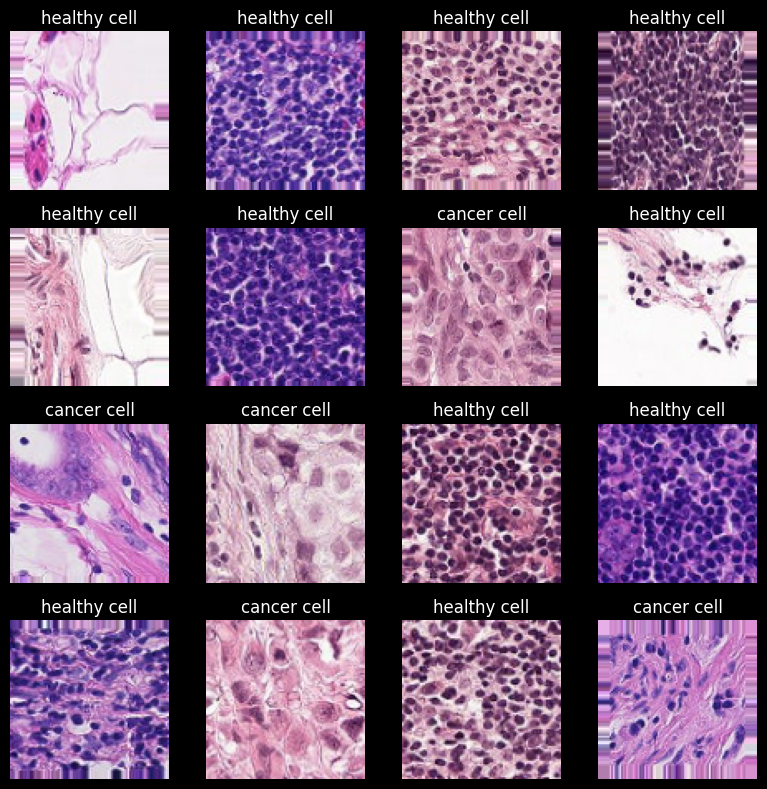

In [ ]:
indices = [random.randint(1, 100) for i in range(16)]

def get_images(generator, index):
  image, label = generator.__getitem__(index)
  return image, label


def plot_images(generator):
  images = []
  subtitles = []
  for index in indices:
    image, label = get_images(generator, index)
    images.append(image[0])
    if (label[0] == 0):
      subtitle = "healthy cell"
    else:
      subtitle = "cancer cell"
    subtitles.append(subtitle)
  fig, axes = plt.subplots(4, 4, figsize=(8, 8))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.title.set_text(subtitles[i])
    ax.axis("off")
  plt.style.use('dark_background')
  plt.tight_layout()
  plt.show()

# Plotting some random images to have a sense of the type of images working
plot_generator = create_train_generator(train_df)
plot_images(plot_generator)



### I kept this part from a previous attempt to train the model with not balanced data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70587 entries, 105935 to 136565
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         70587 non-null  object
 1   label      70587 non-null  object
 2   file_name  70587 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


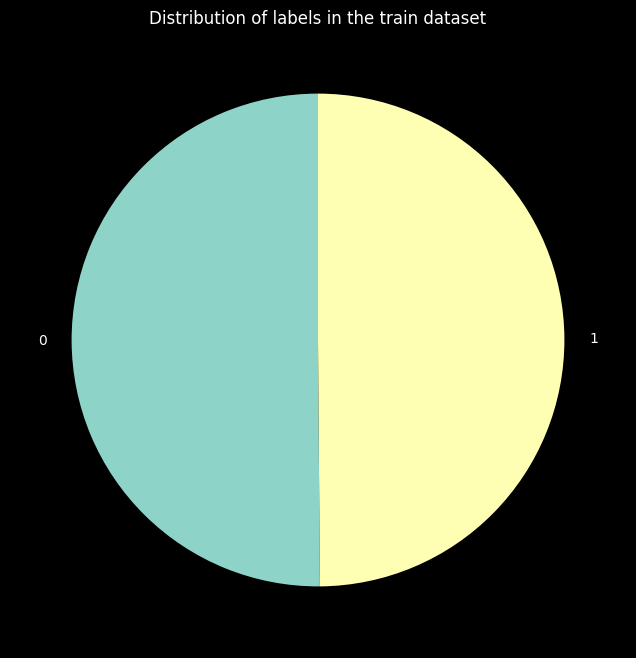

In [ ]:
# Using the labels dataframe to visualize the distribution of labels
train_df.info()
value_counts = train_df.label.value_counts()

plt.style.use('dark_background')
plt.figure(figsize=(8,8))
plt.pie(value_counts, labels= value_counts.index, startangle=90)
plt.title("Distribution of labels in the train dataset")
plt.show()


## A model consisting on a first part with convolutional layers and another part with a dense NN.

The model follows the classic convolutional network architecture for image classification:

[Conv - Conv - Pool] + [Conv - Conv - Pool] + [Dense - Dropout - Dense - Dropout - Dense(Output)]

For tuning I am using Keras tuner and using Hyperband tuner.

In [ ]:
# Install and import Keras Tuner to do Hyperparameter tuning. https://www.tensorflow.org/tutorials/keras/keras_tuner

def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv1_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv2_units', min_value=128, max_value=512, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(hp.Int('dense1_units', min_value=96, max_value=256, step=32), activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(hp.Int('dense2_units', min_value=96, max_value=256, step=32), activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='binary_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='cancer_kaggle2')

In [ ]:
tuning_gen = create_train_generator(train_tuning)
val_tuning_gen = create_val_generator(val_tuning)
tuner.search(tuning_gen, epochs=5)

Trial 10 Complete [00h 06m 43s]
accuracy: 0.7839605212211609

Best accuracy So Far: 0.8360414505004883
Total elapsed time: 00h 41m 59s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - conv1_units: {best_hps.get('conv1_units')}")
print(f" - conv2_units: {best_hps.get('conv2_units')}")
print(f" - dense1_units: {best_hps.get('dense1_units')}")
print(f" - dense2_units: {best_hps.get('dense2_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - conv1_units: 256
 - conv2_units: 384
 - dense1_units: 256
 - dense2_units: 160
 - learning_rate: 0.001


### Hyperparameter tuning:
There are some conclusions from the tuning process:
1. It seems that increasing the filter number in subsequent layers seems to improve the model performance
2. The opposite seems to be true for dense layer. One starts with many perceptrons and then reduce the number in subsequent layers
3. Including the learning rate is a good idea. It seems that there were more model configurations with ok performance with lower learning rates than the default
4. I wanted to use AUC directly as metric for the tuning, but I didnt found how to implemented directly. Attemps to use it indirectly (tuning with accuracy and training with AUC, failed).

### Take the hyperparameters found and build a model with them:

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(96,96,3)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation= 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(160, activation= 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_33 (Conv2D)          (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 44, 44, 256)       147712    
                                                                 
 conv2d_35 (Conv2D)          (None, 42, 42, 384)       885120    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 21, 21, 384)       0         
 ng2D)                                                

In [ ]:
# Create som generators for train and validation data (from dataframes)
train_gen = create_train_generator(train_df)
val_gen = create_val_generator(val_df)

Found 70587 validated image filenames belonging to 2 classes.
Found 17647 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(train_gen, epochs=5, validation_data=val_gen)

Epoch 1/5
2206/2206 [==============================] - 198s 89ms/step - loss: 0.4782 - accuracy: 0.7794 - val_loss: 0.4524 - val_accuracy: 0.7928
Epoch 2/5
2206/2206 [==============================] - 195s 88ms/step - loss: 0.3906 - accuracy: 0.8276 - val_loss: 0.3641 - val_accuracy: 0.8417
Epoch 3/5
2206/2206 [==============================] - 195s 88ms/step - loss: 0.3553 - accuracy: 0.8467 - val_loss: 0.4227 - val_accuracy: 0.8144
Epoch 4/5
2206/2206 [==============================] - 196s 89ms/step - loss: 0.3367 - accuracy: 0.8555 - val_loss: 0.3428 - val_accuracy: 0.8573
Epoch 5/5
2206/2206 [==============================] - 195s 88ms/step - loss: 0.3312 - accuracy: 0.8591 - val_loss: 0.3239 - val_accuracy: 0.8668


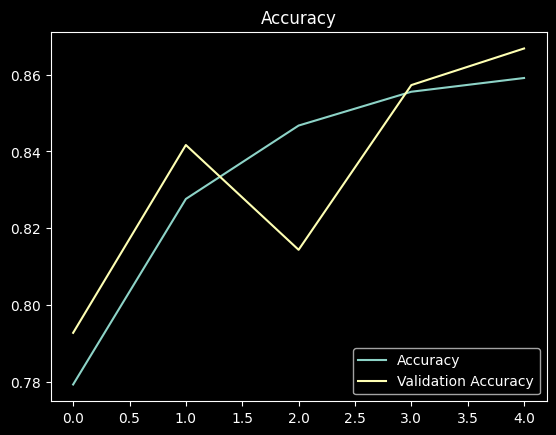

In [ ]:
# Visualizing accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

### I tried to modify the architecture:
 I remove all Pool layers and replaced them with stride in the convolutional layers. I removed a dense layers and use only multiples of 32 in all layers.
 I used AUC directly as metric.

In [ ]:
model_stride = tf.keras.Sequential()
model_stride.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', strides=(2, 2), input_shape=(96,96,3)))
model_stride.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides=(2, 2)))
model_stride.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides=(2, 2)))
model_stride.add(tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', strides=(2, 2)))
model_stride.add(tf.keras.layers.Flatten())
model_stride.add(tf.keras.layers.Dropout(0.2))
model_stride.add(tf.keras.layers.Dense(128, activation= 'relu'))
model_stride.add(tf.keras.layers.Dropout(0.2))
model_stride.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_stride.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model_stride.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 512)         590336    
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
history_stride = model_stride.fit(train_gen, epochs=5, validation_data=val_gen)
# Note that this training was with not balanced data. The performance for training went down when data was balanced for training

Epoch 1/5
2001/2001 [==============================] - 182s 90ms/step - loss: 0.4692 - auc_2: 0.8494 - val_loss: 0.4467 - val_auc_2: 0.8794
Epoch 2/5
2001/2001 [==============================] - 181s 90ms/step - loss: 0.4047 - auc_2: 0.8921 - val_loss: 0.3983 - val_auc_2: 0.9142
Epoch 3/5
2001/2001 [==============================] - 180s 90ms/step - loss: 0.3831 - auc_2: 0.9042 - val_loss: 0.3877 - val_auc_2: 0.9080
Epoch 4/5
2001/2001 [==============================] - 179s 90ms/step - loss: 0.3630 - auc_2: 0.9147 - val_loss: 0.3396 - val_auc_2: 0.9246
Epoch 5/5
2001/2001 [==============================] - 179s 89ms/step - loss: 0.3535 - auc_2: 0.9194 - val_loss: 0.4044 - val_auc_2: 0.9098


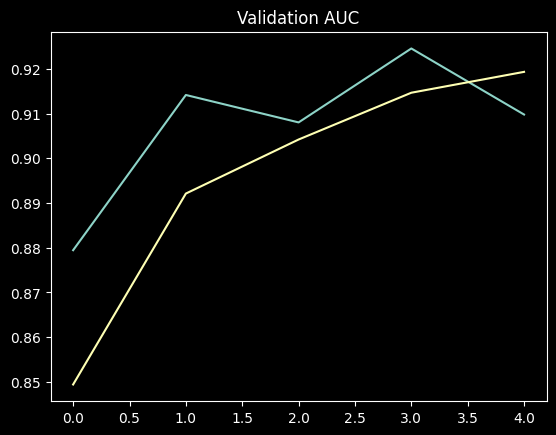

In [ ]:
plt.plot(history_stride.history['val_auc_2'])
plt.plot(history_stride.history['auc_2'])
plt.title("Validation AUC")
plt.show()

### Predictions
To use the model for predictions, the model expects to get the same type of input that was used when trained.
The easiest way to do it is to use a similar ImageDataGenerator, but reading the content of the test folder.
Then predict the values and convert the results to a dataframe.
This will make it easier to put together the predicted values with the ids and create a csv file

In [ ]:
# make a generator with the test data
test_dir = "/content/dataset/test"

def create_test_generator(test_df):
  datagen = ImageDataGenerator(
      rescale = 1./255.
  )

  generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col = "file_name",
    y_col = None,
    target_size = (96, 96),
    batch_size = 1,
    shuffle = False,
    class_mode = None,
    )
  return generator

In [ ]:
# This parse function reads the file path and convert the content of the tif file to a numpy array

test_dir = "/content/dataset/test"
test_df = pd.DataFrame()
test_df['file_name']= [file_name for file_name in os.listdir(test_dir) if file_name.endswith(".tif")]

test_generator = create_test_generator(test_df)

Found 57458 validated image filenames.


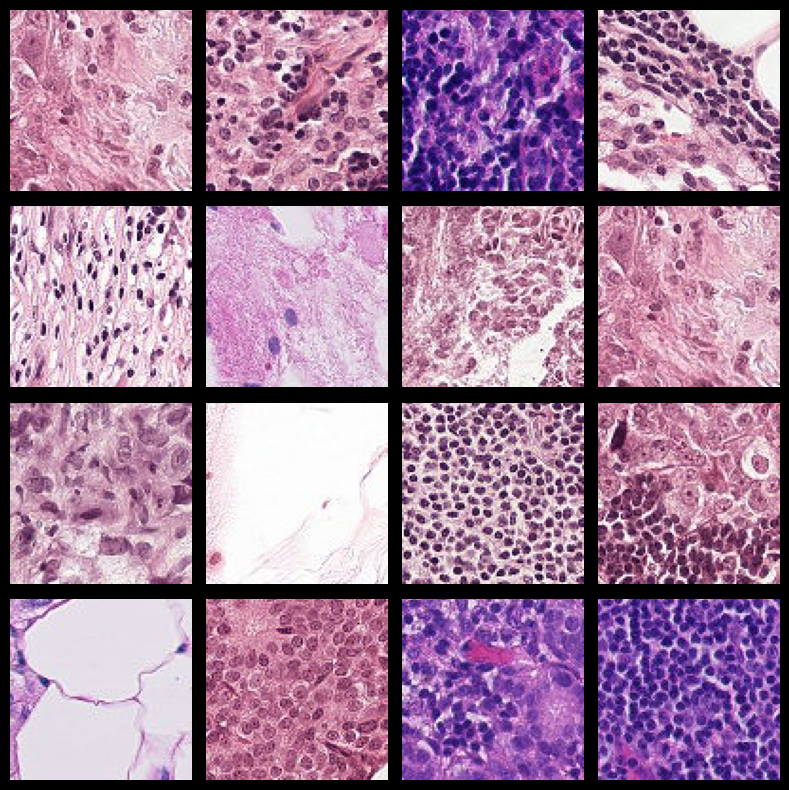

In [ ]:
# Plotting some random images to have a sense of the type of images working
indices = [random.randint(1, 100) for i in range(16)]

def get_images_test(generator, index):
  image = generator.__getitem__(index)
  return image


def plot_images_test(generator):
  images = []
  for index in indices:
    image = get_images_test(generator, index)
    images.append(image[0])

  fig, axes = plt.subplots(4, 4, figsize=(8, 8))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")
  plt.style.use('dark_background')
  plt.tight_layout()
  plt.show()
plot_images_test(test_generator)

In [ ]:
# Predict labels from the trained model
# for element in test_generator[1]:
#   predictions =model.predict(test_generator[1])
# print(predictions)
# classified = np.where(predictions < 0.5, 0, 1)
# print(classified)


pred_labels = model.predict(test_generator)
pred_labels_binary = np.where(pred_labels < 0.5, 0, 1)
pred_labels_format = pred_labels_binary.flatten()


18414


In [ ]:
# Create a dataframe witht the ids and the predicted labels
output_df = pd.DataFrame({'id': test_generator.filenames, 'label': pred_labels_format})
output_df['id'] = output_df['id'].apply(lambda x: x.split(".")[0])

# Export the dataframe to a csv file and download the resulting file
output_df.to_csv("submission.csv", index=False)
files.download("/content/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

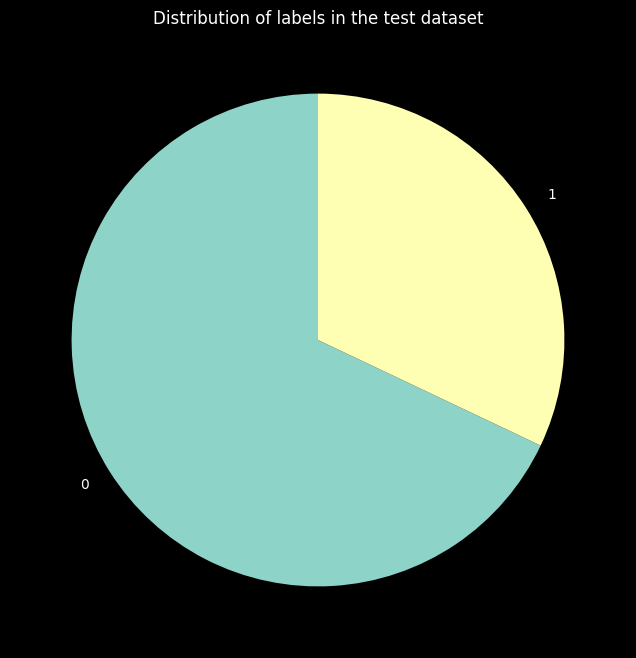

In [ ]:
value_counts = output_df.label.value_counts()

plt.style.use('dark_background')
plt.figure(figsize=(8,8))
plt.pie(value_counts, labels= value_counts.index, startangle=90)
plt.title("Distribution of labels in the test dataset")
plt.show()

## Conclusions:
1. I am happy that the data quality of the data source was quite good and little EDA was a must
2. Most of the problems regarding pre-processing were related to the number of files that the data source was comprise of. I ran into many problems regarding crash on the runtime environment, lack of memory, etc
3. Using TensorFlow datagenerator was effective and offered good performance, but they are less intuitive to work with than Pandas DataFrame
4. Training with not balanced data produced better training results but the predictions were not as good.
5. I suspect that the testdata is balanced and my model has a bias to classify some cancerous cells as healthy
6. I have left at the end of this notebooks some failed attemps I did to construct a functional dataset (for learning purposes)

## Some improvements and further work:
1. Try to use transfer learning and use a model that has been trained previously
2. Use more data. I used only 90K pictures for training and validation. There were 220K
3. Try to run hyperparameter tuning for other layers layers.
4. Try other types of architecture
5. Experiment with other batch sizes

### Some utils to save the models and load them to save training time

In [ ]:
# I use this code to save the models trained so I dont need to train them again
#model.save("model_no_stride.keras")
#files.download("/content/model_no_stride.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the saved models
#files.upload()


Saving model_no_stride.zip to model_no_stride.zip
Saving model_stride.zip to model_stride.zip


{}

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model("/content/model_no_stride.keras")


### Here some previous attempts that ended in failure. DO NOT RUN THE CELLS BELOW. I left them in the notebook just to show different approaches I tried

In [ ]:
# THIS DIDNT WORK BECAUSE THE RESULTING DATASET LACKED INFORMATION ABOUT THE SHAPE (96, 96, None) DESPITE EFFORTS TO CORRECT IT
# Create a dict with labels and ids

train_labels_dict = dict(zip(train.id, train.label))
val_labels_dict = dict(zip(val.id, val.label))

# This parse function reads the file path and convert the content of the tif file to a numpy array
def parse_image(image_path):
  content = tf.io.read_file(image_path)
  image = tfio.experimental.image.decode_tiff(content)
  image = image[:, :, :-1]
  channels = tf.shape(image)[-1]
  image = tf.image.resize(image, [96, 96], method='nearest')
  if (channels != 3):
    image = tf.pad(image, [[0, 0], [0, 0], [0, 3 - channels]])
  channels = tf.shape(image)[-1]
  if (channels != 3):
    print("Still files with different channels than 3")
  return tf.reshape(image, (96, 96, 3))

# This is just a simple string method to remove the sufix of the file .tif
def extract_id(file_name):
  return str(file_name).split(".")[0]


# This methods uses the label dictionary and look up the label by using the id. If the id is not found which means that the file is in the validation set, it returns -1
def extract_label(file_name, label_dict):
  id = extract_id(file_name)
  label = label_dict.get(id)
  if label == None:
    label = -1
  return label

# Make a dataset for training

# Create a list with paths, ids and labels using list comprehension and the methods previously defined
train_dir = "/content/dataset/train"
image_paths_and_file_name_and_label = [(os.path.join(train_dir, file_name), extract_label(file_name, train_labels_dict)) for file_name in os.listdir(train_dir) if file_name.endswith(".tif")]

# Separate the tuples due to problems with parsing the dataset, I got an error that TensorFlow was trying to assigned different type values to same tensor
image_paths = [x[0] for x in image_paths_and_file_name_and_label]
labels = np.array([x[1] for x in image_paths_and_file_name_and_label])

# Create a dataset with the list and use map to get the image contents
dataset_before = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(lambda x, y: (parse_image(x), y))


# Filter out all images that are not in the train dataset
train_dataset = dataset.filter(lambda image, label: label != -1)

# Make a dataset for validation

# Create a list with paths, ids and labels using list comprehension and the methods previously defined
image_paths_and_file_name_and_label = [(os.path.join(train_dir, file_name), extract_label(file_name, val_labels_dict)) for file_name in os.listdir(train_dir) if file_name.endswith(".tif")]

# Separate the tuples due to problems with parsing the dataset, I got an error that TensorFlow was trying to assigned different type values to same tensor
image_paths = [x[0] for x in image_paths_and_file_name_and_label]
labels = [x[1] for x in image_paths_and_file_name_and_label]

# Create a dataset with the list and use map to get the image contents
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(lambda image, label: (parse_image(image), label))

# Filter out all images that are not in the train dataset
val_dataset = dataset.filter(lambda image, label: label != -1)


In [ ]:
# THIS DIDNT WORK BECAUSE IT COULD ONLY PROCESS 45 FILES PER SECOND IN COLAB AND THAT WOULD HAVE TAKEN AROUND 80-90 MINUTES. IT WAS ALSO HORRIBLY TO TROUBLESHOOT!!!
#https://www.learndatasci.com/solutions/python-move-file/
train_ids = list(train['id'])
val_ids = list(val['id'])

def move_files_by_id_train(ids):
  train_dir = "/content/dataset/train"
  for id in ids:
    label = labels_df.loc[labels_df['id'] == id, 'label']
    if label == 0:
      folder = "healthy"
    if label == 1:
      folder = "cancer"
    file_name = id + ".tif"
    source = os.path.join(train_dir, file_name)
    destination = os.path.join(train_dir, folder, file_name)
    shutil.move(source, destination)

def move_files_by_id_val(ids):
  train_dir = "/content/dataset/train"
  val_dir = "/content/dataset/val"
  counter = 0
  for id in ids:
    counter += 1
    label = labels_df.loc[labels_df['id'] == id, 'label'].values
    if label == 0:
      folder = "healthy"
    else:
      folder = "cancer"
    file_name = id + ".tif"
    source = os.path.join(train_dir, file_name)
    destination = os.path.join(val_dir, folder, file_name)
    try:
       shutil.move(source, destination)
    except:
      "Didnt find file"

    if counter % 2000 == 0:
      print("Files processed are: ", counter)
  print("Total processed files were: ", counter)

move_files_by_id_val(val_ids)

Files processed are:  2000
Files processed are:  4000
Files processed are:  6000
Files processed are:  8000
Files processed are:  10000
Total processed files were:  11002


### Using TensorFlow to create datasets from images in train and test folders

In [ ]:
# THIS DIDNT WORK BECAUSE THIS TF FUNCTION DOES NOT SUPPORT TIF FILES AND THE FILES HAS TO BE PLACED IN FOLDER REPRESENTING THEIR CATEGORY

batch_size = 32
#img_height = 100
#img_width = 100
image_directory = "dataset"

train_dataset = tf.keras.utils.image_dataset_from_directory(
   image_directory,
   seed=1,
   validation_split=0.2,
   shuffle=True,
   subset='training',
   #image_size=(img_height, img_width),
   batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
   image_directory,
   seed=1,
   validation_split=0.2,
   shuffle=True,
   subset='validation',
   #image_size=(img_height, img_width),
   batch_size=batch_size
)

Found 220014 files belonging to 2 classes.
Using 176012 files for training.
Found 220014 files belonging to 2 classes.
Using 44002 files for validation.
